# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data



## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

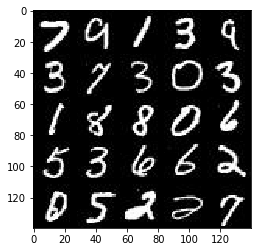

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

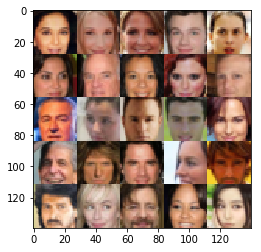

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    #real inputs to discriminator
    real_inputs = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels),name='real_inputs')
    
    #noise input to generator
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    
    #learning rate input
    lr = tf.placeholder(tf.float32,name='lr')

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [32]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    #use discriminator scope so we know where to update weights later
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer,  28x28 images with 3 layers deep (R G B)
        # pass it throught a 2d conv layer 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True) #batch normalization
        relu1 = tf.maximum(alpha * bn1, bn1)#leaky relu activation
        
        # Now is 14x14x64
        #print ('Discrimator Layer 1:',relu1.shape)
      
        #second conv layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        #batch normalize before leaky relu
        bn2 = tf.layers.batch_normalization(x2, training=True)
        #leaky relu
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Now is 7x7x128
        #print ('Discrimator Layer 2:',relu2.shape)
        
        #Third conv layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid')
        #batch normalize before leaky relu
        bn3 = tf.layers.batch_normalization(x3, training=True)
        #leaky relu
        relu3 = tf.maximum(alpha * bn3, bn3)

        #Now is 4x4x256
        #print ('Discrimator Layer 3:',relu3.shape)
        
        # Flatten the final layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        # pass through normal fully conected layer and output single decision output
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    #if training do not reuse graph so weights will update
    if is_train==True:
        reuse = False
    else: #if generating instead of training reuse weights
        reuse = True

    #use generator scope so we know where to update weights later
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer from random noise vector
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape for convolutions, very deep but narrow right now
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #batch normalize
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        
        # Now is 2x2x512
        #print ('Generator Layer 1:',x1.shape)

        #Use transpose convolution to progressively flatten and widen layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        #batch normalize
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        #leaky relu
        x2 = tf.maximum(alpha * x2, x2)
        
        #print ('Generator Layer 2:',x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #batch normalize
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        #leaky relu
        x3 = tf.maximum(alpha * x3, x3)
        
        # Now is 7x7x128
        #print ('Generator Layer 3:',x3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
       
        # 28x28xoutput_channel_dim
        #print ('Output Layer:',logits.shape)
        
        out = tf.tanh(logits) 
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    #generator model
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    #descriminator model for real data
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    #descriminator model for fake data
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    #descriminator loss for real images
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    #descriminator loss for real images
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    #generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    #descriminator total loss is the sum of the real and fake losses
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get list the trainable_variables
    t_vars = tf.trainable_variables()
    #split list into generator variables to train and descriminator variables to train
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    #update operations
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #generator weight updates
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    #descriminator weight updates
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    #controls the dependency of the operations performed to update weights on generator
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #determine if the image is grayscale or RGB, this determinites image depth (channels)
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    #get image width and height 
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    #generate the inputs to the network based on image
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #create nodes for the descriminator and generator losses
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    
    #create nodes for the optimization routines
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #these will be used to keep track of training and take samples throughout
    batch_num = 0
    losses = []
    samples = []
    
    # get generator variables 
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    
    #save generator checkpoint
    saver = tf.train.Saver(var_list=g_vars)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                
                # Get random input for the generator and scale to between -1 and 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers on the descriminator and generator
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                #increase the batch number
                batch_num += 1
                
                #show output every 100 batches to see how it is doing
                if (batch_num%100 == 0):
                    show_generator_output(sess=sess, image_mode=data_image_mode, input_z=input_z, n_images=10, out_channel_dim=image_channels)
            
            # Get losses at end of each epoch
            train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})
            
            #print losses at each epochs end
            print("Epoch {}/{}...".format(epoch_i+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))    
            
            # Save losses to list for potential graphing later on
            losses.append((train_loss_d, train_loss_g))

            # Sample from generator as we're training to see how it is doing
            sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
            gen_samples = sess.run(
                           generator(input_z, image_channels, is_train=False),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples)
            
            #save session as checkpoint
            saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

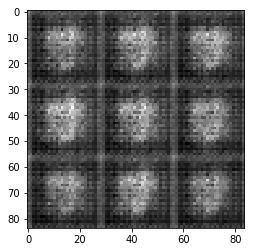

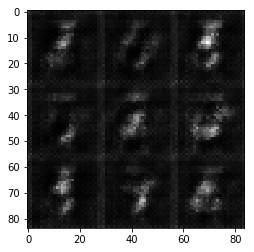

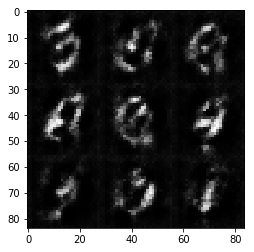

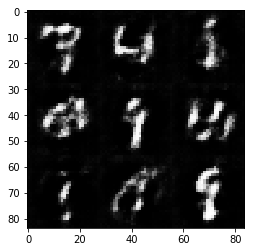

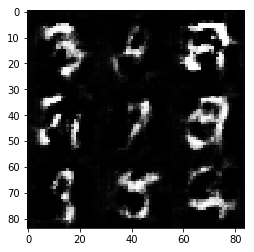

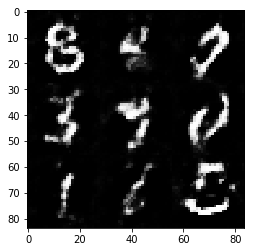

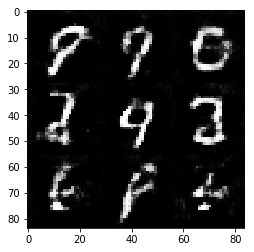

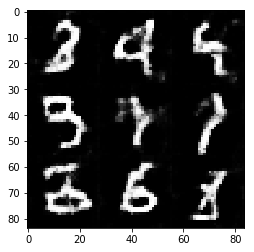

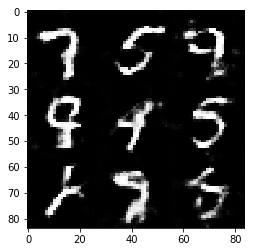

Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 0.8333


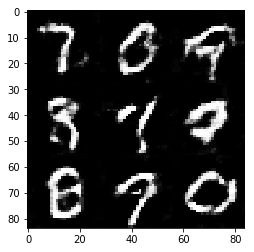

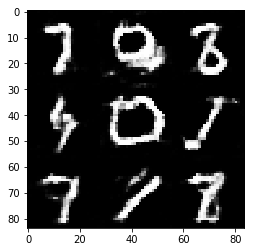

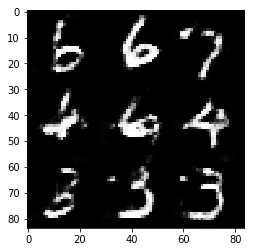

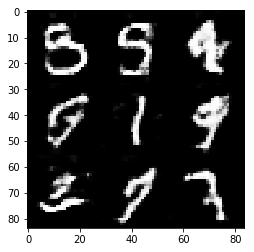

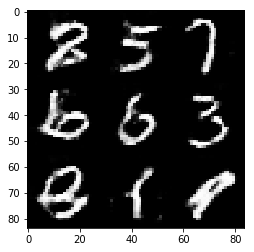

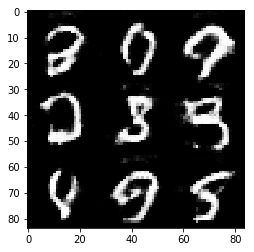

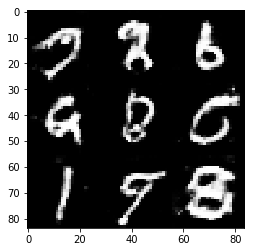

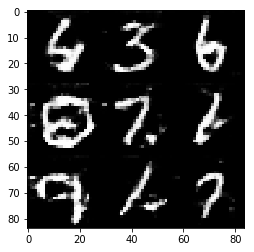

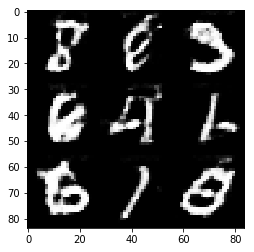

Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.6275


In [40]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

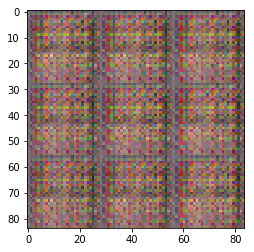

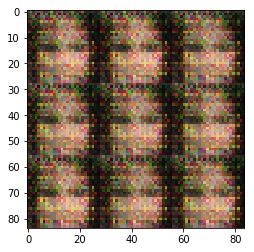

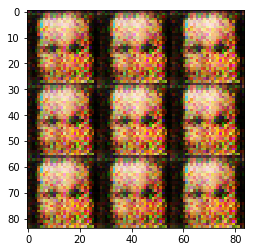

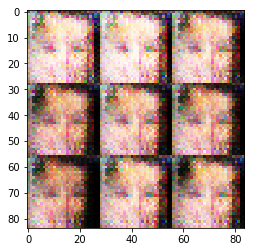

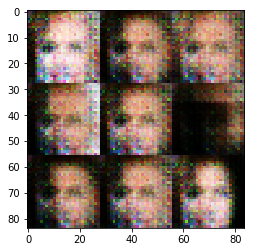

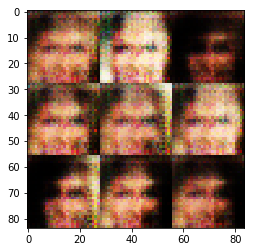

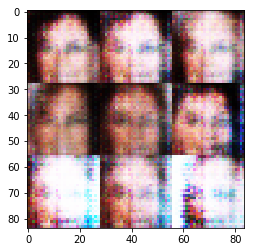

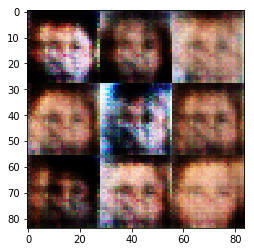

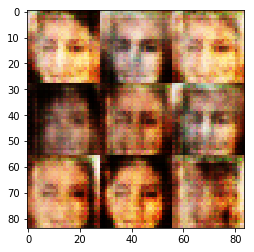

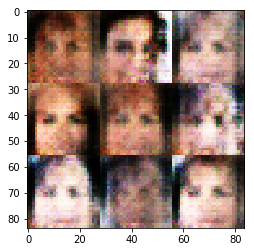

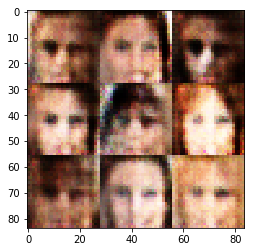

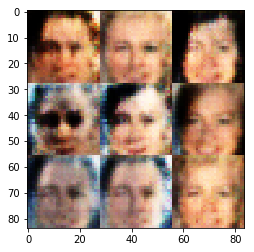

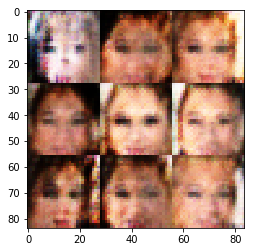

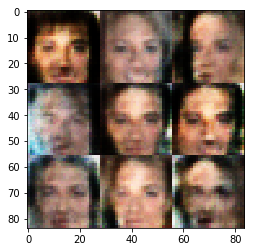

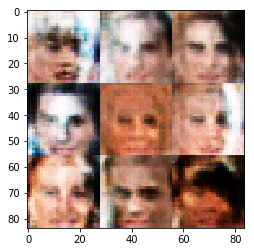

Epoch 1/5... Discriminator Loss: 1.1180... Generator Loss: 0.7491


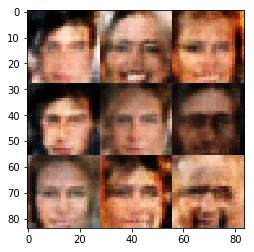

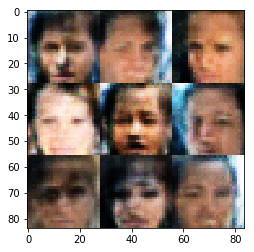

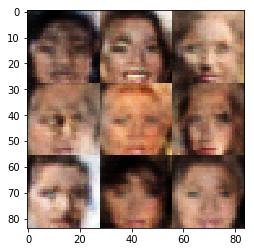

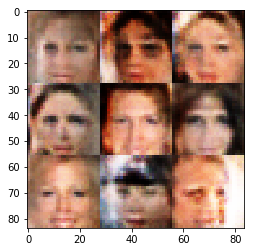

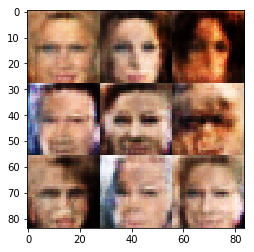

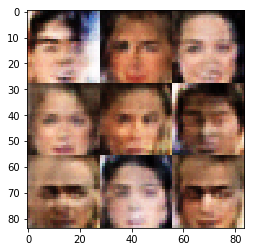

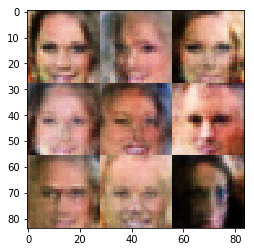

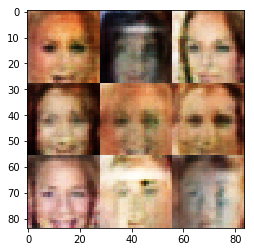

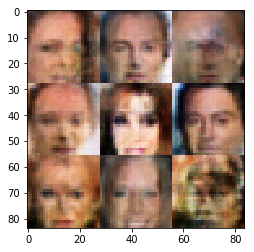

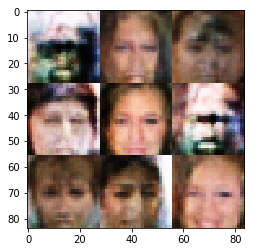

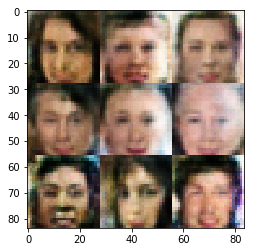

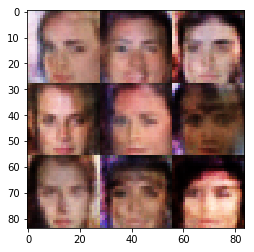

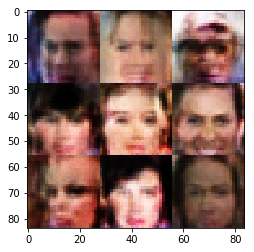

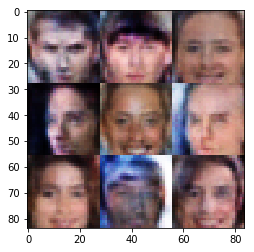

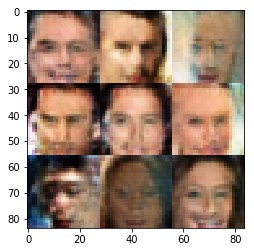

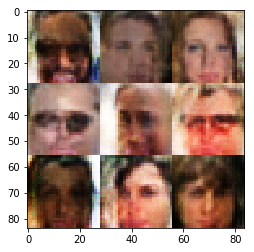

Epoch 2/5... Discriminator Loss: 0.9134... Generator Loss: 0.9642


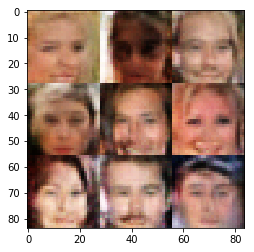

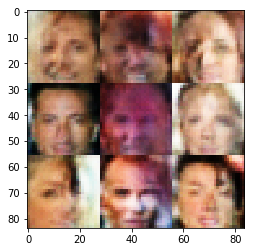

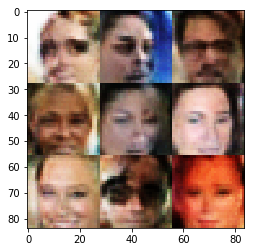

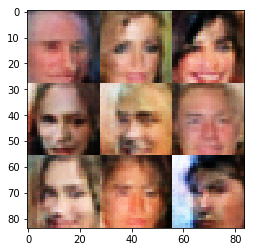

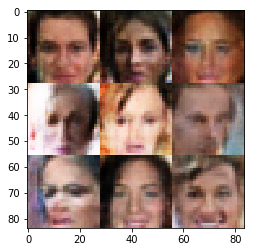

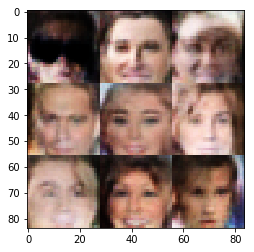

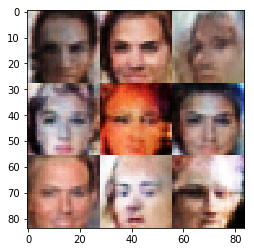

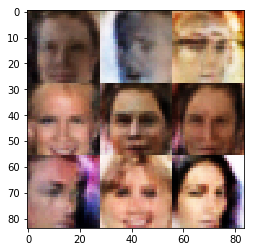

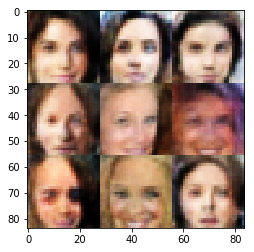

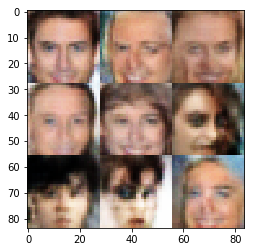

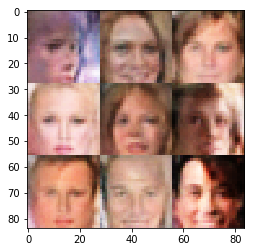

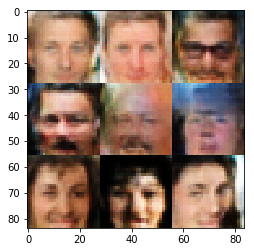

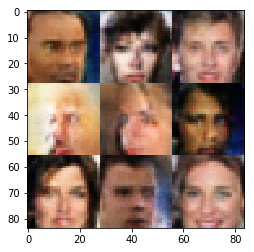

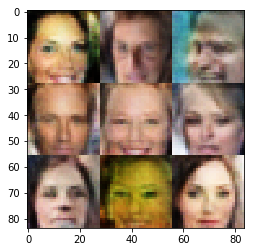

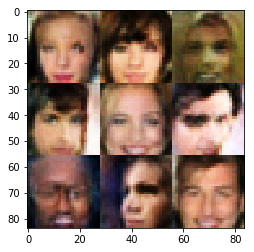

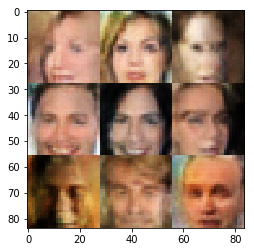

Epoch 3/5... Discriminator Loss: 0.9374... Generator Loss: 0.7397


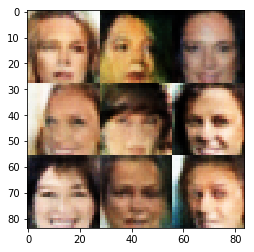

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.